In [2]:
import pandas as pd

In [3]:
# Read CSV file into a DataFrame
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')

print(df.head())

   Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28                Doctor             6.2   
3          4   Male   28  Sales Representative             5.9   
4          5   Male   28  Sales Representative             5.9   

   Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                 6                       42             6   Overweight   
1                 6                       60             8       Normal   
2                 6                       60             8       Normal   
3                 4                       30             8        Obese   
4                 4                       30             8        Obese   

  Blood Pressure  Heart Rate  Daily Steps Sleep Disorder  
0         126/83          77         4200            NaN  
1         125/80          75      

In [4]:
# Select specific columns from the DataFrame
columns = ['Person ID', 'Occupation','Sleep Duration','Quality of Sleep','Physical Activity Level','Stress Level']

# Create a new DataFrame with only the selected columns
file = df[columns].copy()

print(file.head())
print("rows:",len(file))

   Person ID            Occupation  Sleep Duration  Quality of Sleep  \
0          1     Software Engineer             6.1                 6   
1          2                Doctor             6.2                 6   
2          3                Doctor             6.2                 6   
3          4  Sales Representative             5.9                 4   
4          5  Sales Representative             5.9                 4   

   Physical Activity Level  Stress Level  
0                       42             6  
1                       60             8  
2                       60             8  
3                       30             8  
4                       30             8  
rows: 374


In [5]:
# Print number of missing values for each column
print("Missing values per column:")
print(file.isnull().sum())

Missing values per column:
Person ID                  0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
dtype: int64


In [6]:
# Set minimum sample size for occupations
min_sample = 10

# Count the number of people in each occupation
job_counts = file['Occupation'].value_counts()

# Keep only occupations with more than the minimum sample size
valid_jobs = job_counts[job_counts > min_sample].index

# Filter the DataFrame to include only valid occupations
filtered_df = file[file['Occupation'].isin(valid_jobs)]

print("Number of vailid occupation:", len(valid_jobs))
print("Number of deleted occupation:", (len(job_counts)-len(valid_jobs)))
print(f"Number of falid job in dataset: {len(filtered_df)}")

Number of vailid occupation: 7
Number of deleted occupation: 4
Number of falid job in dataset: 363


In [7]:
Q1 = filtered_df['Quality of Sleep'].quantile(0.25)
Q3 = filtered_df['Quality of Sleep'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows with 'Quality of Sleep' outside the bounds
clean_data = filtered_df[(filtered_df['Quality of Sleep'] >= lower_bound) & (filtered_df['Quality of Sleep'] <= upper_bound)]

# Count how many outliers were removed
outliers_count = len(filtered_df) - len(clean_data)

print(f"Number of outliers in Quality of Sleep: {outliers_count}")
print(clean_data[['Occupation', 'Quality of Sleep']])


Number of outliers in Quality of Sleep: 0
    Occupation  Quality of Sleep
1       Doctor                 6
2       Doctor                 6
6      Teacher                 6
7       Doctor                 7
8       Doctor                 7
..         ...               ...
369      Nurse                 9
370      Nurse                 9
371      Nurse                 9
372      Nurse                 9
373      Nurse                 9

[363 rows x 2 columns]


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

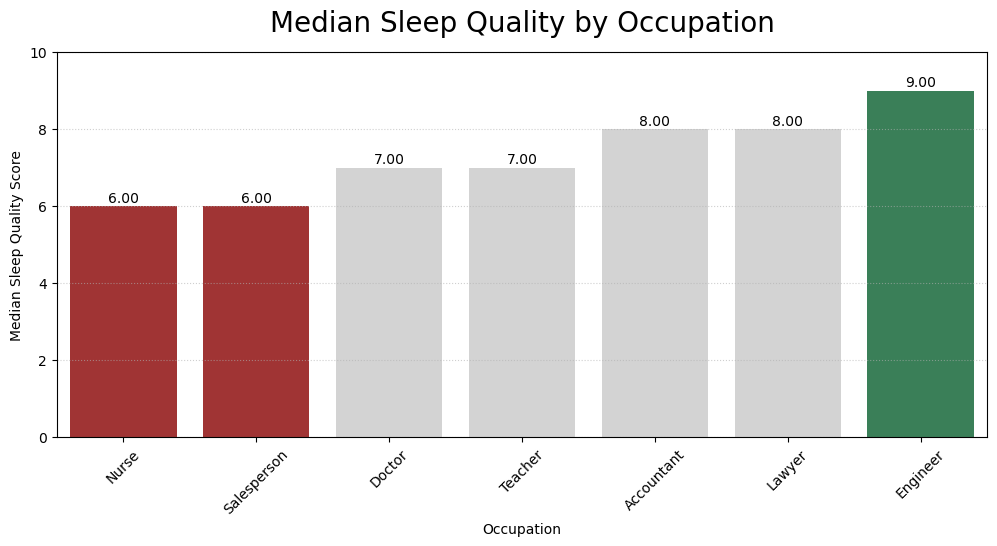

In [9]:
# Create a box plot 
median_sleep = (
    clean_data
    .groupby('Occupation')['Quality of Sleep']
    .median()
    .reset_index(name='Median Sleep Quality')
    .sort_values(by='Median Sleep Quality', ascending=True)
)

threshold = 6  
palette = [
    'firebrick' if val <= threshold else
    'seagreen' if occ == 'Engineer' else
    'lightgray'
    for occ, val in zip(median_sleep['Occupation'], median_sleep['Median Sleep Quality'])
]

plt.figure(figsize=(12,5))
sns.barplot(
    data=median_sleep,
    x='Occupation',
    y='Median Sleep Quality',
    hue='Occupation',
    palette=palette,
    legend=False,
)

plt.title('Median Sleep Quality by Occupation', fontsize=20, pad=15)
plt.xlabel('Occupation')
plt.ylabel('Median Sleep Quality Score')
plt.xticks(rotation=45)
plt.ylim(0,10)
plt.grid(axis='y', linestyle=':', alpha=0.6)

for i, val in enumerate(median_sleep['Median Sleep Quality']):
    plt.text(i, val + 0.1, f'{val:.2f}', ha='center', fontsize=10)


plt.show()

In [10]:
# Group data by Occupation and calculate statistics for Quality of Sleep
grouped = clean_data.groupby('Occupation')['Quality of Sleep'].agg([
    ('variance','var'),
    ('Q1', lambda x: x.quantile(0.25)),
    ('Q2 (median)', 'median'),
    ('Q3', lambda x: x.quantile(0.75))
]).reset_index()

# Sort occupations by median sleep quality in ascending order
grouped_sorted_asc = grouped.sort_values(by='Q2 (median)', ascending=True)

print(grouped_sorted_asc)

    Occupation  variance   Q1  Q2 (median)   Q3
4        Nurse  2.402968  6.0          6.0  9.0
5  Salesperson  0.000000  6.0          6.0  6.0
1       Doctor  0.574245  6.0          7.0  7.0
6      Teacher  0.435256  7.0          7.0  7.0
0   Accountant  0.210210  8.0          8.0  8.0
3       Lawyer  0.097132  8.0          8.0  8.0
2     Engineer  0.568868  8.0          9.0  9.0


In [11]:
lowest_sleep_job = grouped_sorted_asc.iloc[0]
print(f"The occupation with the lowest median sleep quality is {lowest_sleep_job['Occupation']} (Median = {lowest_sleep_job['Q2 (median)']})")
highest_sleep_job = grouped_sorted_asc.iloc[-1]
print(f"The occupation with the highest median sleep quality is {highest_sleep_job['Occupation']} (Median = {highest_sleep_job['Q2 (median)']})")    

The occupation with the lowest median sleep quality is Nurse (Median = 6.0)
The occupation with the highest median sleep quality is Engineer (Median = 9.0)


In [12]:
from scipy import stats

# Perform one-way ANOVA test on Quality of Sleep for different occupations
f_value, p_value = stats.f_oneway(clean_data[clean_data['Occupation'] == 'Accountant']['Quality of Sleep'],
                                  clean_data[clean_data['Occupation'] == 'Doctor']['Quality of Sleep'],
                                  clean_data[clean_data['Occupation'] == 'Engineer']['Quality of Sleep'],
                                  clean_data[clean_data['Occupation'] == 'Lawyer']['Quality of Sleep'],
                                  clean_data[clean_data['Occupation'] == 'Nurse']['Quality of Sleep'],
                                  clean_data[clean_data['Occupation'] == 'Salesperson']['Quality of Sleep'],
                                  clean_data[clean_data['Occupation'] == 'Teacher']['Quality of Sleep'])

print(f"ANOVA result: f-value = {f_value:.2f}, p-value {p_value:.2f}")

ANOVA result: f-value = 41.65, p-value 0.00


In [13]:
if p_value < 0.05:
    print("Alternative Hypothesis: There is a statistically significant difference in sleep quality across occupational groups.")
else:
    print("Null Hypothesis: There is no statistically significant difference in sleep quality across occupational groups.")

Alternative Hypothesis: There is a statistically significant difference in sleep quality across occupational groups.


In [14]:
import numpy as np

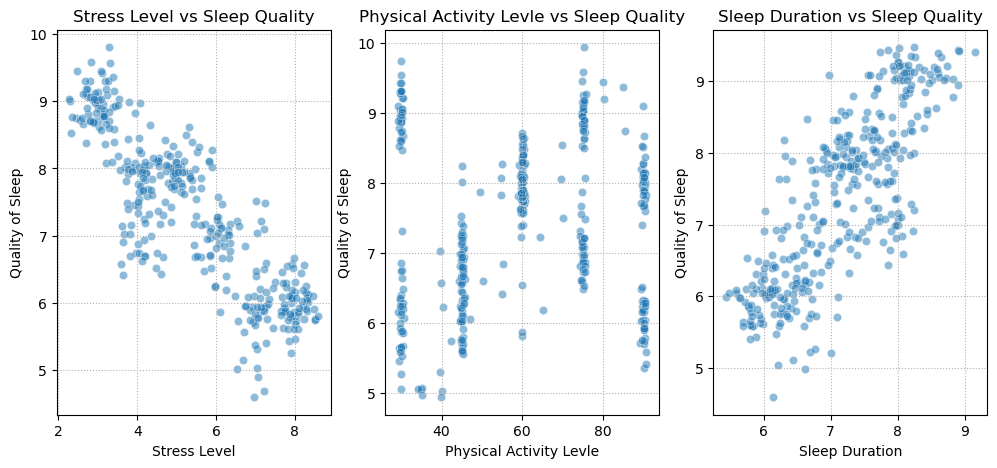

In [15]:
# Function to add random noise
def jitter(series, strength=0.3):
    return series + np.random.normal(0, strength, size=series.shape)

plt.figure(figsize=(12,5))

# Define variables to compare with Quality of Sleep
variables = {
    'Stress Level': clean_data['Stress Level'],
    'Physical Activity Levle': clean_data['Physical Activity Level'],
    'Sleep Duration': clean_data['Sleep Duration']
}

# Create scatter plots for each variable vs Quality of Sleep
for i, (name, var) in enumerate(variables.items(), 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(
        x=jitter(var),
        y=jitter(clean_data['Quality of Sleep']),
        alpha = 0.5
    )
    plt.xlabel(name)
    plt.ylabel('Quality of Sleep')
    plt.title(f'{name} vs Sleep Quality', fontsize=12)
    plt.grid(True, linestyle=':')
    
plt.show()

In [16]:
from scipy.stats import pearsonr

In [17]:
# Define independent variables (X) and dependent variable (y)
X= ['Stress Level', 'Physical Activity Level','Sleep Duration']
y = 'Quality of Sleep'
results = []

# Calculate Pearson correlation for each variable in X with Quality of Sleep
for col in X:
    x_col = clean_data[col]
    y_col = clean_data[y]
    r, p = pearsonr(x_col, y_col)
    results.append({
        'Variable': col, 
        'Pearson r': round(r,2), 
        'p-value': round(p, 2)
    })

# Convert results to DataFrame for easy viewing
result_df = pd.DataFrame(results)
print(result_df)

                  Variable  Pearson r  p-value
0             Stress Level      -0.91     0.00
1  Physical Activity Level       0.15     0.01
2           Sleep Duration       0.88     0.00


In [18]:
# Initialize variable to store the strongest absolute correlation value
strongest_r = 0

# Loop through the correlation results to find the highest absolute value
for i in range (3):
    current_r = abs(result_df.loc[i, 'Pearson r'])
    if strongest_r > current_r:
        strongest_r = strongest_r
    else: 
        strongest_r = current_r

print (f"Strongest absolute correlation value among factors: {strongest_r}")

# Check if Stress Level has the strongest correlation
if abs(result_df.loc[0, 'Pearson r']) == strongest_r :
    print("Alternative Hypothesis: Stress level has the strongest correlation with sleep quality")
else:
    print("Null Hypothesis: There is a variable with a stronger correlation than stress")

Strongest absolute correlation value among factors: 0.91
Alternative Hypothesis: Stress level has the strongest correlation with sleep quality


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [20]:
# Split dataset into training and testing sets (80% train, 20% test)
X= clean_data[['Stress Level', 'Physical Activity Level','Sleep Duration']]
y = clean_data['Quality of Sleep']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

model = LinearRegression()

# Create and train a Linear Regression model
model.fit(X_train, y_train)

# Predict Quality of Sleep using the test data
y_pred = model.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squred: {r2:.4f}")
print(f"MSE: {mse:.4f}")

R-squred: 0.8856
MSE: 0.1470


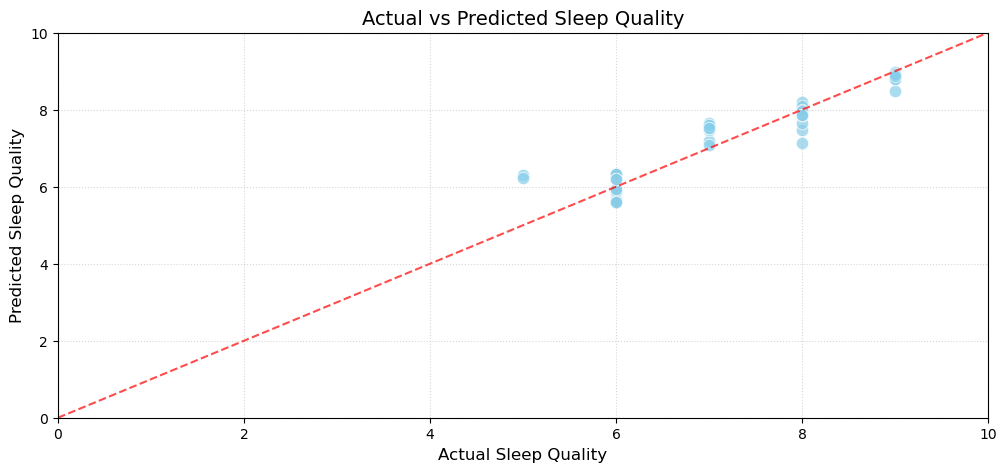

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12,5))

# Scatter plot
sns.scatterplot(
    x=y_test,
    y=y_pred,
    s=80,
    alpha=0.7,
    color='skyblue'
)

# 45-degree reference line 
lims = [0, 10]  
plt.plot(lims, lims, 'r--', alpha=0.7)

plt.xlabel('Actual Sleep Quality', fontsize=12)
plt.ylabel('Predicted Sleep Quality', fontsize=12)
plt.title('Actual vs Predicted Sleep Quality', fontsize=14)
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True, linestyle=':', alpha=0.5)

plt.show()


In [22]:
if r2 >= 0.5:
    print("Alternative Hypothesis: The model predicts sleep quality with 'moderately high' accracy")
else:
    print("Null Hypothesis: The model's explanatory power is insufficient")

Alternative Hypothesis: The model predicts sleep quality with 'moderately high' accracy
